In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

%matplotlib inline

## Get the data with gsutil 

In [2]:
!mkdir -pa ../data/quick_draw/raw/
!gsutil -m cp gs://draw-me-a-sheep/images/* ../data/quick_draw/raw/

Copying gs://draw-me-a-sheep/images/apple.npy...
Copying gs://draw-me-a-sheep/images/elephant.npy...
Copying gs://draw-me-a-sheep/images/car.npy...
Copying gs://draw-me-a-sheep/images/snake.npy...                                
Copying gs://draw-me-a-sheep/images/key.npy...
Copying gs://draw-me-a-sheep/images/cat.npy...
Copying gs://draw-me-a-sheep/images/hat.npy...                                  
Copying gs://draw-me-a-sheep/images/river.npy...                                
Copying gs://draw-me-a-sheep/images/clock.npy...                                
Copying gs://draw-me-a-sheep/images/sheep.npy...                                
Resuming download for data/quick_draw/raw/hat.npy component 1                   
Resuming download for data/quick_draw/raw/hat.npy component 0


In [3]:
def load_np_data(path):
    import os
  
    data = []
    labels = []
    images_files = list(filter(lambda x: x.endswith('npy'), os.listdir(path)))
    label_names = [x.split('.')[0] for x in images_files]
    class_mapping = {}
    for i in range(len(images_files)):
        class_mapping[i] = label_names[i]
        print(os.path.join(path, images_files[i]))
        samples = np.load(os.path.join(path, images_files[i]))[:8000]
        data.append(samples)
        labels.append(np.array([i] * len(samples)))

    return (np.concatenate(data) / 255.0 , np.concatenate(labels)), class_mapping

In [4]:
(X, y), mappings = load_np_data('../data/quick_draw/raw/')

../data/quick_draw/raw/elephant.npy
../data/quick_draw/raw/car.npy
../data/quick_draw/raw/apple.npy
../data/quick_draw/raw/clock.npy
../data/quick_draw/raw/sheep.npy
../data/quick_draw/raw/cat.npy
../data/quick_draw/raw/key.npy
../data/quick_draw/raw/snake.npy
../data/quick_draw/raw/river.npy
../data/quick_draw/raw/hat.npy


## View Data 

/usr/local/envs/py2env/lib/python2.7/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


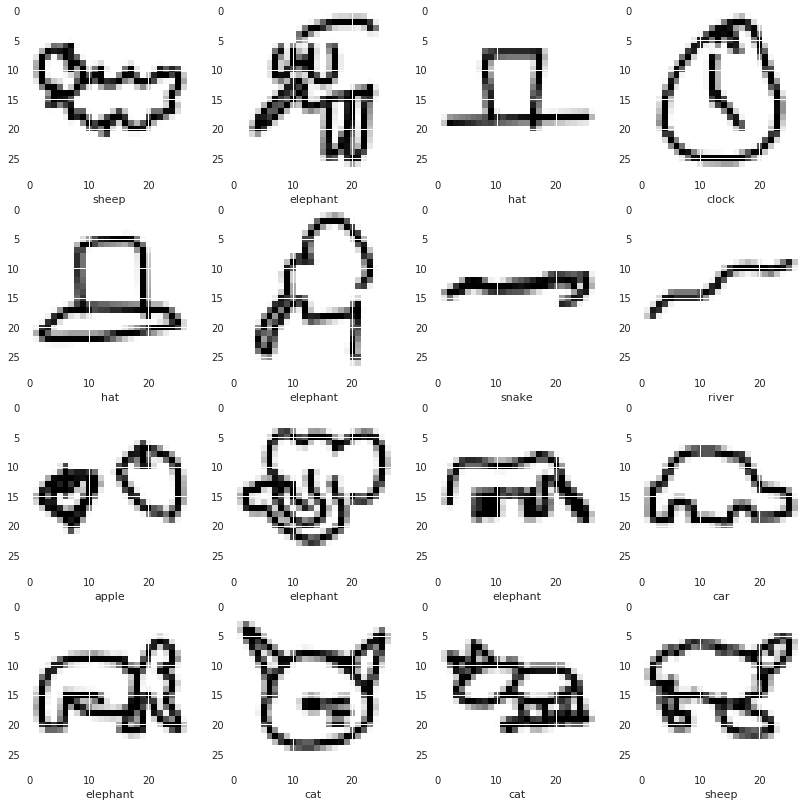

In [5]:
plt.figure (figsize=(14,14))
for i in range(16):
    plt.subplot(4,4,i+1)
    i = np.random.randint(0,len(X), size=1)[0]
    plt.imshow(X[i].reshape(28,28), interpolation='none')
    plt.xlabel(mappings[y[i]])

## Train a model 

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [7]:
n_classes = 10

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, input_shape=(28*28,)),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(n_classes, activation=tf.nn.softmax)
])

In [9]:
model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
model.fit(X_train, tf.keras.utils.to_categorical(y_train), epochs=5)


Epoch 1/5
56000/56000 [==============================] - 24s 425us/step - loss: 0.8695 - acc: 0.7127
Epoch 2/5
56000/56000 [==============================] - 6s 111us/step - loss: 0.6744 - acc: 0.7811
Epoch 3/5
56000/56000 [==============================] - 6s 113us/step - loss: 0.6105 - acc: 0.8033
Epoch 4/5
56000/56000 [==============================] - 6s 112us/step - loss: 0.5645 - acc: 0.8176
Epoch 5/5
56000/56000 [==============================] - 6s 112us/step - loss: 0.5337 - acc: 0.8289


## Improve model

In [11]:
cnn_model = tf.keras.Sequential([
    tf.keras.layers.Reshape(target_shape=(28,28, 1), input_shape=(28 * 28,)),
    tf.keras.layers.Conv2D(32, 5, padding='same', activation=tf.nn.relu),
    tf.keras.layers.Conv2D(16, 5, padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), (2, 2), padding='same'),
    tf.keras.layers.Conv2D(32, 5, padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), (2, 2), padding='same'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(n_classes, activation=tf.nn.softmax)
])

In [12]:
cnn_model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
cnn_model.fit(X_train, tf.keras.utils.to_categorical(y_train), epochs=5)


Epoch 1/5
56000/56000 [==============================] - 19s 344us/step - loss: 0.5678 - acc: 0.8185
Epoch 2/5
56000/56000 [==============================] - 13s 227us/step - loss: 0.3133 - acc: 0.9021
Epoch 3/5
56000/56000 [==============================] - 13s 228us/step - loss: 0.2388 - acc: 0.9233
Epoch 4/5
56000/56000 [==============================] - 13s 228us/step - loss: 0.1871 - acc: 0.9390
Epoch 5/5
56000/56000 [==============================] - 13s 228us/step - loss: 0.1458 - acc: 0.9521


In [14]:
cnn_model.evaluate(X_test, tf.keras.utils.to_categorical(y_test))

24000/24000 [==============================] - 2s 94us/step


[0.3244066310636699, 0.9094583333333334]

## See what and why we got wrong

In [15]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i].reshape(28,28)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(mappings[predicted_label],
                                100*np.max(predictions_array),
                                mappings[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
 
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

In [16]:
predictions = cnn_model.predict(X_test)

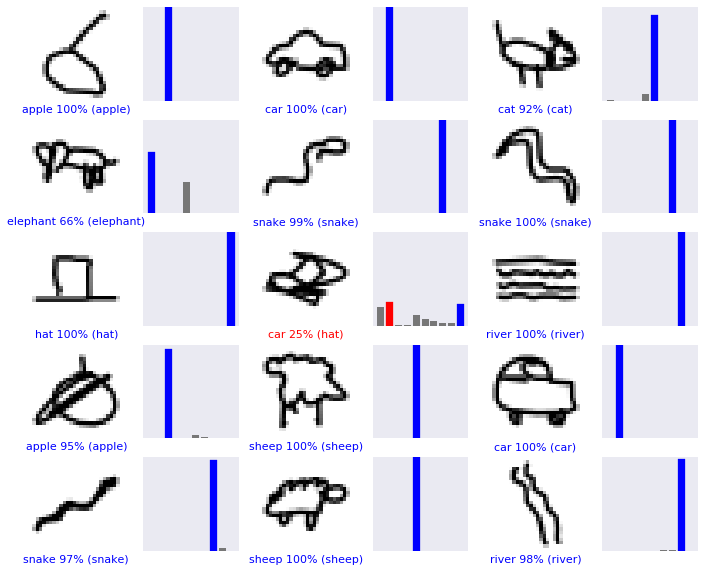

In [24]:
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  img_i = np.random.randint(0,len(predictions), size=1)[0]
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(img_i, predictions, y_test, X_test)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(img_i, predictions, y_test)